In [ ]:
import pandas as pd
import requests

# Baixar os dados do link
url = "https://n8n.coinverge.com.br/webhook/precos"
response = requests.get(url)
data = response.json()

# Converter para DataFrame
df = pd.DataFrame(data)

# Exemplo de conversão de tipos de dados
# Ajuste conforme os tipos reais dos dados
for col in df.columns:
    # Tenta converter para numérico, se possível
    df[col] = pd.to_numeric(df[col], errors='ignore')

# Exibe os tipos de dados convertidos
print(df.dtypes)
df.head()

In [ ]:
import numpy as np

# Função para simular a estratégia de stop loss dinâmica
def simular_stop_estrategia(df):
    df = df.sort_values(['simbolo', 'datahora_fechamento']).copy()
    df['stop'] = np.nan
    df['retorno_estrategia'] = np.nan
    df['acumulado_estrategia'] = np.nan
    df['retorno_real'] = (df['ultimo_preco'] - df['preco_abertura']) / df['preco_abertura']
    df['acumulado_real'] = df.groupby('simbolo')['retorno_real'].transform(lambda x: (1 + x).cumprod())


    for simbolo, grupo in df.groupby('simbolo'):
        idx = grupo.index
        stop_vals = []
        retorno_estrategia = []
        acumulado = []
        prev_stop = None
        prev_acumulado = 1

        for i in range(len(grupo)):
            fechamento = grupo.iloc[i]['ultimo_preco']
            minimo = grupo.iloc[i]['preco_minimo']
            abertura = grupo.iloc[i]['preco_abertura']

            # Calcula o stop do próximo dia com base no dia anterior
            if i > 0:
                prev_fechamento = grupo.iloc[i-1]['ultimo_preco']
                prev_minimo = grupo.iloc[i-1]['preco_minimo']
                prev_stop = (prev_fechamento - prev_minimo) / prev_fechamento
            else:
                prev_stop = np.nan

            stop_vals.append(prev_stop)

            # Simula a estratégia
            if np.isnan(prev_stop):
                retorno = (fechamento - abertura) / abertura
            else:
                stop_preco = abertura * (1 - prev_stop)
                if minimo <= stop_preco:
                    # Stop ativado: vende no preço de stop
                    retorno = (stop_preco - abertura) / abertura
                else:
                    # Stop não ativado: vende no fechamento
                    retorno = (fechamento - abertura) / abertura

            retorno_estrategia.append(retorno)
            prev_acumulado *= (1 + retorno)
            acumulado.append(prev_acumulado)

        df.loc[idx, 'stop'] = stop_vals
        df.loc[idx, 'retorno_estrategia'] = retorno_estrategia
        df.loc[idx, 'acumulado_estrategia'] = acumulado

    return df

# Exemplo de uso:
resultado = simular_stop_estrategia(df)
# Exibe as primeiras linhas do resultado para conferência
resultado[['simbolo', 'datahora_fechamento', 'preco_abertura', 'ultimo_preco', 'preco_minimo', 'stop', 'retorno_estrategia', 'acumulado_estrategia', 'retorno_real', 'acumulado_real']].head(20)

In [ ]:
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class BacktestSimulador:
    def __init__(self, df, simbolo, params=None):
        self.df = df[df['simbolo'] == simbolo].copy()
        self.simbolo = simbolo
        self.params = params if params else {}
        self.preditores = self.params.get('preditores', [
            'rsi_14', 'mm_exp_21', 'razao_amplitude', 'max_div_min', 'ret_dia_anterior'
        ])
        self.modelo = self.params.get('modelo', DecisionTreeClassifier(random_state=42))
        self.stop_loss = self.params.get('stop_loss', {'tipo': 'fixo', 'valor': 0.05})
        self.proporcao_teste = self.params.get('proporcao_teste', 0.25)
        self.DEBUG = self.params.get('DEBUG', False)
        self._prepara_dados()

    def _prepara_dados(self):
        # Calcula indicadores técnicos
        self.df['rsi_14'] = RSIIndicator(close=self.df['ultimo_preco'], window=14).rsi()
        self.df['mm_exp_21'] = EMAIndicator(close=self.df['ultimo_preco'], window=21).ema_indicator()
        self.df['razao_amplitude'] = (self.df['preco_maximo'] - self.df['preco_minimo']) / self.df['preco_abertura']
        self.df['max_div_min'] = self.df['preco_maximo'] / self.df['preco_minimo']
        self.df['ret_dia_anterior'] = self.df['ultimo_preco'].pct_change()
        self.df['target'] = self.df['variacao_futura_de_preco_binaria']
        self.df = self.df.dropna(subset=self.preditores + ['target'])

    def treina_modelo(self):
        X = self.df[self.preditores]
        y = self.df['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.proporcao_teste, random_state=42)
        self.modelo.fit(X_train, y_train)
        y_pred = self.modelo.predict(X_test)
        self.acuracia = accuracy_score(y_test, y_pred)
        if self.DEBUG:
            print(f'Acurácia do modelo para {self.simbolo}: {self.acuracia:.4f}')

    def simula_estrategia(self):
        # Exemplo de simulação simples com stop loss fixo
        df_sim = self.df.copy()
        df_sim['sinal'] = self.modelo.predict(df_sim[self.preditores])
        df_sim['retorno'] = 0.0
        stop_valor = self.stop_loss['valor']
        for i in range(1, len(df_sim)):
            if df_sim.iloc[i]['sinal'] == 1:
                abertura = df_sim.iloc[i]['preco_abertura']
                fechamento = df_sim.iloc[i]['ultimo_preco']
                minimo = df_sim.iloc[i]['preco_minimo']
                stop_preco = abertura * (1 - stop_valor)
                if minimo <= stop_preco:
                    retorno = (stop_preco - abertura) / abertura
                else:
                    retorno = (fechamento - abertura) / abertura
                df_sim.iat[i, df_sim.columns.get_loc('retorno')] = retorno
        df_sim['acumulado'] = (1 + df_sim['retorno']).cumprod()
        self.resultado = df_sim

    def getRetornoMedioHorario(self):
        a = self.df.copy()
        a = a.reset_index()[['ultimo_preco', 'datahora_fechamento']]
        a['hora_inicio'] = pd.to_datetime(a['datahora_fechamento']).dt.hour
        a['retorno_abertura_fechamento'] = a['ultimo_preco'].pct_change()
        a = a.dropna()
        return a.groupby('hora_inicio')['retorno_abertura_fechamento'].mean()

# Exemplo de uso:
# sim = BacktestSimulador(df, simbolo, params={'DEBUG': True})
# sim.treina_modelo()
# sim.simula_estrategia()
# print(sim.resultado.head())

In [ ]:
# Classe de backtest com stop dinâmico e campos vazios na primeira linha de cada ativo
class BacktestStopDinamico:
    def __init__(self, df):
        self.df = df.copy()
        self.resultados = {}

    def simular(self):
        for simbolo, grupo in self.df.groupby('simbolo'):
            grupo = grupo.sort_values('datahora_fechamento').copy()
            grupo['stop'] = np.nan
            grupo['retorno_estrategia'] = np.nan
            grupo['acumulado_estrategia'] = np.nan
            grupo['variacao_acumulado_max_desceu'] = np.nan

            prev_stop = None
            prev_acumulado = 1
            max_acumulado = 1
            stop_vals = []
            retorno_estrategia = []
            acumulado = []
            variacao_max_desceu = []

            for i in range(len(grupo)):
                if i == 0:
                    # Primeira linha: campos vazios
                    stop_vals.append(np.nan)
                    retorno_estrategia.append(np.nan)
                    acumulado.append(np.nan)
                    variacao_max_desceu.append(np.nan)
                    continue

                fechamento = grupo.iloc[i]['ultimo_preco']
                minimo = grupo.iloc[i]['preco_minimo']
                abertura = grupo.iloc[i]['preco_abertura']

                prev_fechamento = grupo.iloc[i-1]['ultimo_preco']
                prev_minimo = grupo.iloc[i-1]['preco_minimo']
                prev_stop = (prev_fechamento - prev_minimo) / prev_fechamento
                stop_vals.append(prev_stop)

                stop_preco = abertura * (1 - prev_stop)
                if minimo <= stop_preco:
                    retorno = (stop_preco - abertura) / abertura
                else:
                    retorno = (fechamento - abertura) / abertura

                retorno_estrategia.append(retorno)
                prev_acumulado *= (1 + retorno)
                acumulado.append(prev_acumulado)
                max_acumulado = max(max_acumulado, prev_acumulado)
                variacao_max_desceu.append((prev_acumulado - max_acumulado) / max_acumulado)

            grupo['stop'] = stop_vals
            grupo['retorno_estrategia'] = retorno_estrategia
            grupo['acumulado_estrategia'] = acumulado
            grupo['variacao_acumulado_max_desceu'] = variacao_max_desceu

            self.resultados[simbolo] = grupo

    def plot_tabelas(self):
        i=0
        for simbolo, resultado in self.resultados.items():  # Limitar a plotar apenas os 2 primeiros ativos
            i=i+1
            if i<2:
                print(f"Tabela de resultados para {simbolo}:")
                # print(f"Tabela de resultados para {simbolo}:")
                # display(resultado[['datahora_fechamento', 'preco_abertura', 'ultimo_preco', 'preco_minimo', 'stop', 'retorno_estrategia', 'acumulado_estrategia', 'variacao_acumulado_max_desceu']].head(20))
                resultado[['acumulado_estrategia']].plot(title=f'Resultados para {simbolo}')
# Exemplo de uso:
backtest = BacktestStopDinamico(df)
backtest.simular()
backtest.plot_tabelas()

Tabela de resultados para 1INCHUSDT:


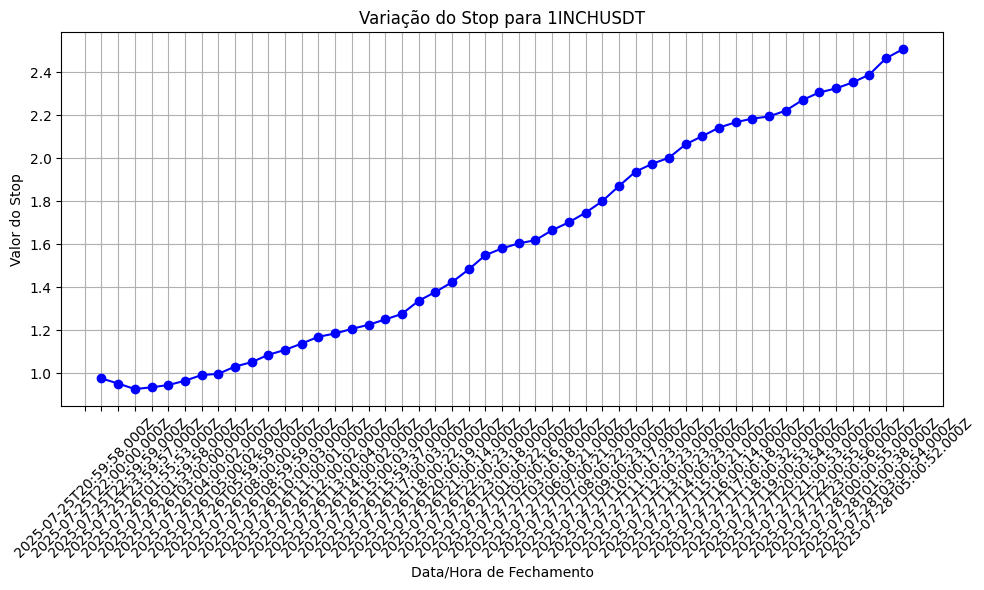

Tabela de resultados para 1MBABYDOGEUSDT:


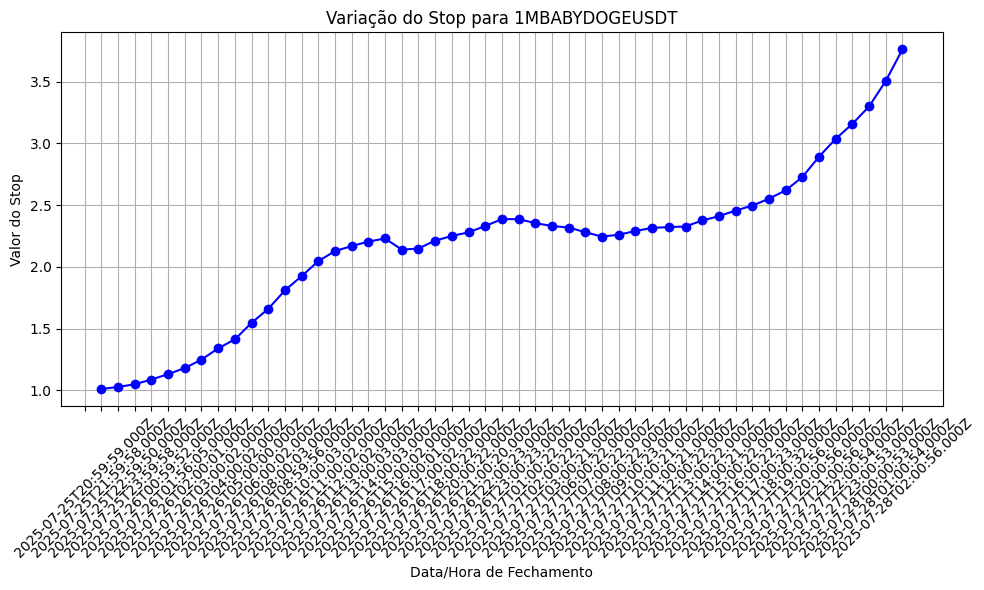

Tabela de resultados para AAVEUSDT:


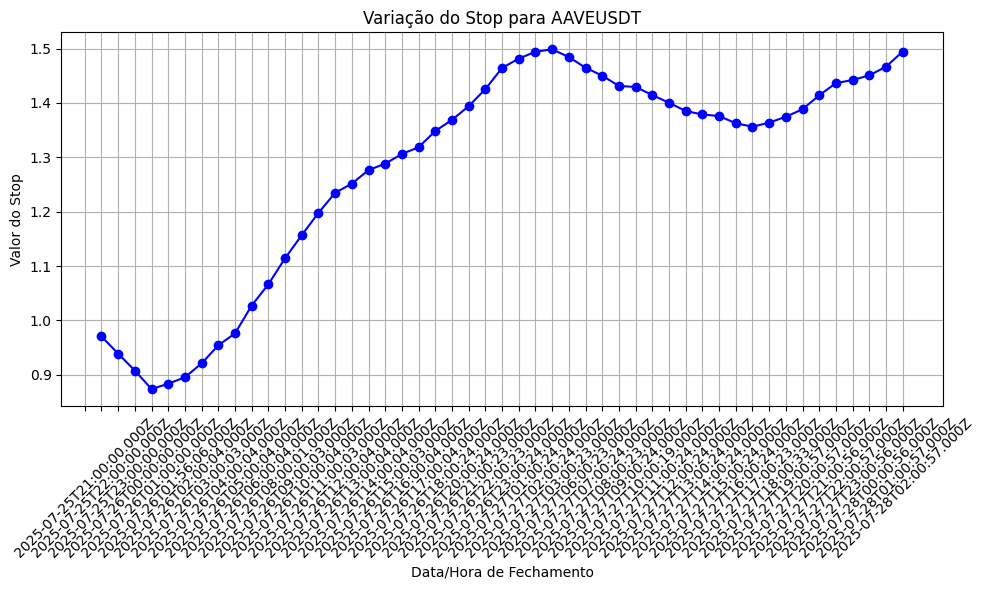

Tabela de resultados para ACHUSDT:


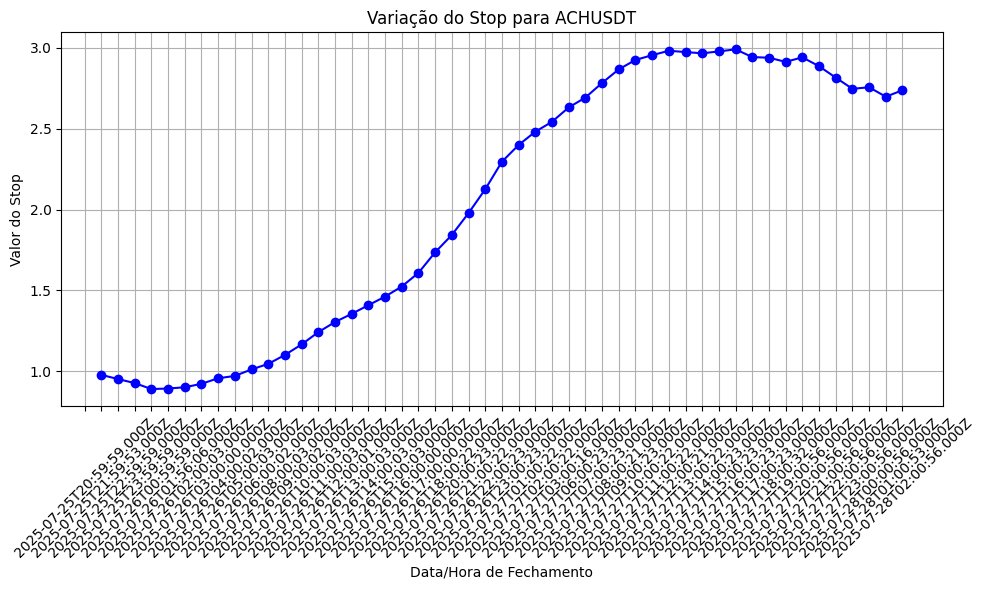

Tabela de resultados para ACXUSDT:


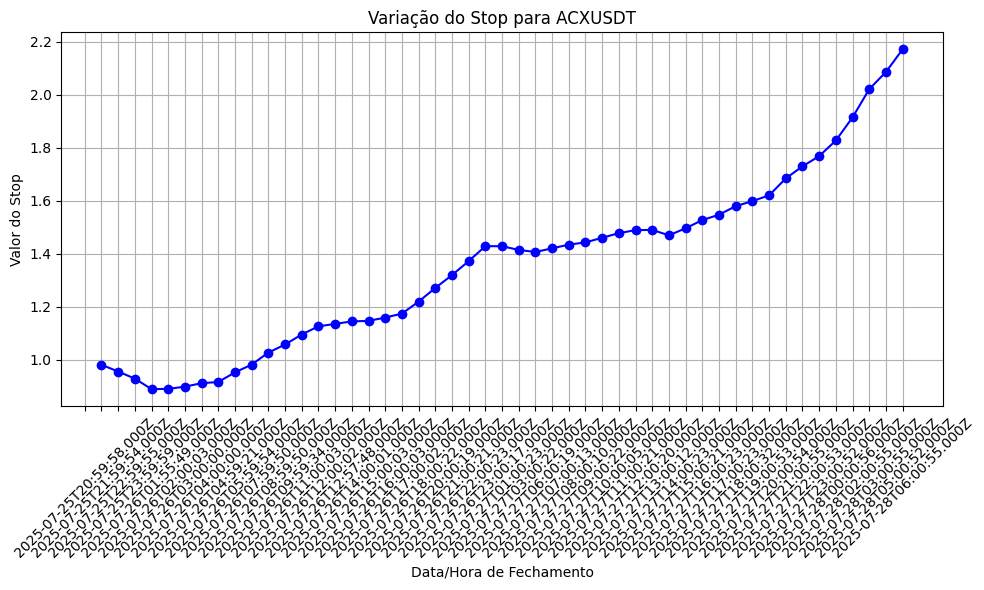

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display  # Para display em Jupyter

class BacktestStopDinamico:
    def __init__(self, df):
        self.df = df.copy()
        self.resultados = {}

    def simular(self):
        for simbolo, grupo in self.df.groupby('simbolo'):
            if len(grupo) < 24:
                continue  # Remove ativos com menos de 24 registros
            
            grupo = grupo.sort_values('datahora_fechamento').copy()
            grupo['stop'] = np.nan
            grupo['retorno_estrategia'] = np.nan
            grupo['acumulado_estrategia'] = np.nan
            grupo['variacao_acumulado_max_desceu'] = np.nan

            prev_stop = None
            prev_acumulado = 1
            max_acumulado = 1
            stop_vals = []
            retorno_estrategia = []
            acumulado = []
            variacao_max_desceu = []

            for i in range(len(grupo)):
                if i == 0:
                    # Primeira linha: campos vazios
                    stop_vals.append(np.nan)
                    retorno_estrategia.append(np.nan)
                    acumulado.append(np.nan)
                    variacao_max_desceu.append(np.nan)
                    continue

                fechamento = grupo.iloc[i]['ultimo_preco']
                minimo = grupo.iloc[i]['preco_minimo']
                abertura = grupo.iloc[i]['preco_abertura']

                prev_fechamento = grupo.iloc[i-1]['ultimo_preco']
                prev_minimo = grupo.iloc[i-1]['preco_minimo']
                prev_stop = (prev_fechamento - prev_minimo) / prev_fechamento # ISSO ESTA ERRADO
                stop_vals.append(prev_stop)

                stop_preco = abertura * (1 - prev_stop)
                if minimo <= stop_preco:
                    retorno = (stop_preco - abertura) / abertura
                else:
                    retorno = (fechamento - abertura) / abertura

                retorno_estrategia.append(retorno)
                prev_acumulado *= (1 + retorno)
                acumulado.append(prev_acumulado)
                max_acumulado = max(max_acumulado, prev_acumulado)
                variacao_max_desceu.append((prev_acumulado - max_acumulado) / max_acumulado)

            grupo['stop'] = stop_vals
            grupo['retorno_estrategia'] = retorno_estrategia
            grupo['acumulado_estrategia'] = acumulado
            grupo['variacao_acumulado_max_desceu'] = variacao_max_desceu

            self.resultados[simbolo] = grupo

    def plot_tabelas(self):
        # Limitar o número de ativos plotados para evitar sobrecarga de desempenho (ex: primeiros 5)
        simbolos_para_plotar = list(self.resultados.keys())  # Ajuste o número conforme necessário
        i=0
        for simbolo in self.resultados.keys():
            if i < 5:  # Limitar a plotar apenas os 2 primeiros
                i=i+1
                resultado = self.resultados[simbolo]
                # print(f"Tabela de resultados para {simbolo}:")
                print(f"Tabela de resultados para {simbolo}:")
                # display(resultado[['datahora_fechamento', 'preco_abertura', 'ultimo_preco', 'preco_minimo', 'stop', 'retorno_estrategia', 'acumulado_estrategia', 'variacao_acumulado_max_desceu']].head(20))
                
                # Plotar gráfico da variação do stop por ativo, mas apenas se for um dos selecionados e com poucos registros (ex: head(50))
                if simbolo in simbolos_para_plotar:
                    df_plot = resultado.head(50)  # Limitar a 50 registros para desempenho
                    plt.figure(figsize=(10, 6))
                    plt.plot(df_plot['datahora_fechamento'], df_plot['acumulado_estrategia'], marker='o', linestyle='-', color='b')
                    plt.title(f'Variação do Stop para {simbolo}')
                    plt.xlabel('Data/Hora de Fechamento')
                    plt.ylabel('Valor do Stop')
                    plt.xticks(rotation=45)
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()

# Exemplo de uso:
backtest = BacktestStopDinamico(df)
backtest.simular()
backtest.plot_tabelas()
